# Football Manager 2024 - Player Valuation Analysis

An attempt to model player valuation based on their attributes to find undervalued attributes.

### Data Loading

In [68]:
import pandas as pd
import numpy as np
import datetime as dt

file = "data/Export 10K players.rtf"
df = pd.read_csv(file, delimiter="|")

### Data Pre-Processing

In [69]:
df = df.rename(columns=str.strip) #stripping column names
df.dropna(subset=["Height"], inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)

# Strip spaces, and convert wage to a float
df["Wage"] = df["Wage"].str.strip()
df["Wage"] = df["Wage"].str.replace("£", "", regex=True)
df["Wage"] = df["Wage"].str.replace(",", "", regex=True)
df["Wage"] = df["Wage"].str.replace(" p/w", "", regex=True)
df["Wage"] = df["Wage"].astype(float)

# Handling the string for transfer value and creating an average float value between min and max estimate.
df[["Min Value", "Max Value"]] = df["Transfer Value"].str.split(" - ", expand=True)
df["Min Value"] = df["Min Value"].str.strip().str.replace("£", "")
df["Min Value"] = df["Min Value"].replace("Not for Sale", np.nan)
df["Max Value"] = df["Max Value"].str.strip().str.replace("£", "")

def convert_values(value):
    if pd.isna(value):
        return np.nan
    elif "M" in value:
        return float(value.replace("M", "")) * 1000000
    elif "K" in value:
        return float(value.replace("K", "")) * 1000
    else:
        return float(value)
    
df["Min Value"] = df["Min Value"].apply(convert_values)
df["Max Value"] = df["Max Value"].apply(convert_values)
df["Avg Value"] = (df["Min Value"] + df["Max Value"]) / 2

# Converting the height data into cm
df[["height_feet", "height_inch"]]= pd.DataFrame(df["Height"].str.strip().str.replace('"', "").str.split("'").to_list(), index=df.index).astype(int)
df["height_cm"] = (((df["height_feet"] * 12) + (df["height_inch"])) * 2.54).astype(float)


# Converting the contract expiry date into years remaining
start_date = dt.datetime.strptime('2023-09-01', "%Y-%m-%d")
df["Expires"] = pd.to_datetime(df["Expires"], dayfirst=True)
df["Months Remaining"] = round(((df["Expires"] - start_date).dt.days / 30.4375),0)


# Drop any rows will nulls.
df = df.dropna()


# Outputting the cleansed data to csv for checking
df.to_csv("output.csv")

### Exploratory Data Analysis

count    1.055400e+04
mean     5.878477e+06
std      1.523408e+07
min      2.000000e+05
25%      6.600000e+05
50%      1.325000e+06
75%      4.400000e+06
max      2.235000e+08
Name: Avg Value, dtype: float64


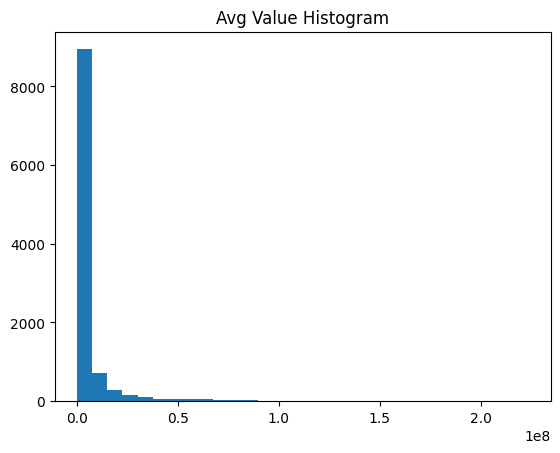

In [70]:
import matplotlib.pyplot as plt

print(df["Avg Value"].describe())

plt.hist(df["Avg Value"], bins=30)
plt.title("Avg Value Histogram")
plt.show()

As you can see, the target variable is heavily right skewed. Therefore, I will apply a log transformation.

count    10554.000000
mean        14.403762
std          1.368437
min         12.206078
25%         13.399997
50%         14.096924
75%         15.297115
max         19.224922
Name: Log Avg Value, dtype: float64


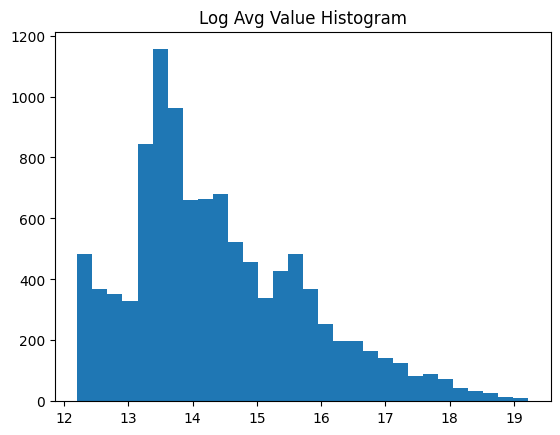

In [71]:
df["Log Avg Value"] = np.log1p(df["Avg Value"])
print(df["Log Avg Value"].describe())
plt.hist(df["Log Avg Value"], bins=30)
plt.title("Log Avg Value Histogram")
plt.show()

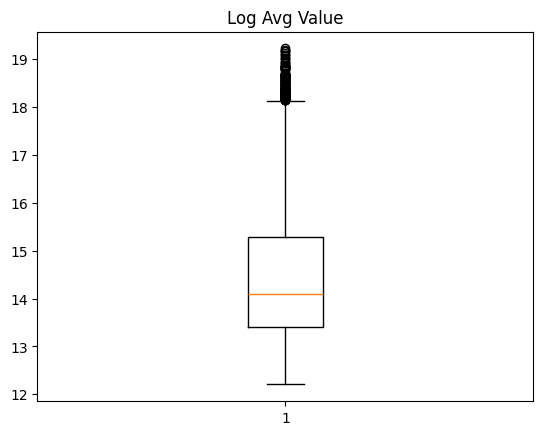

In [72]:
# Going to plot a boxplot to check for outliers after applying log transformation on y.

plt.boxplot(x=df["Log Avg Value"])
plt.title("Log Avg Value")
plt.show()

There appears to be a lot of outliers. I am going to remove these.

In [73]:
Q1 = df["Log Avg Value"].quantile(0.25)
Q3 = df["Log Avg Value"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)

df = df[(df["Log Avg Value"] >= lower_bound) & (df["Log Avg Value"] <= upper_bound)]

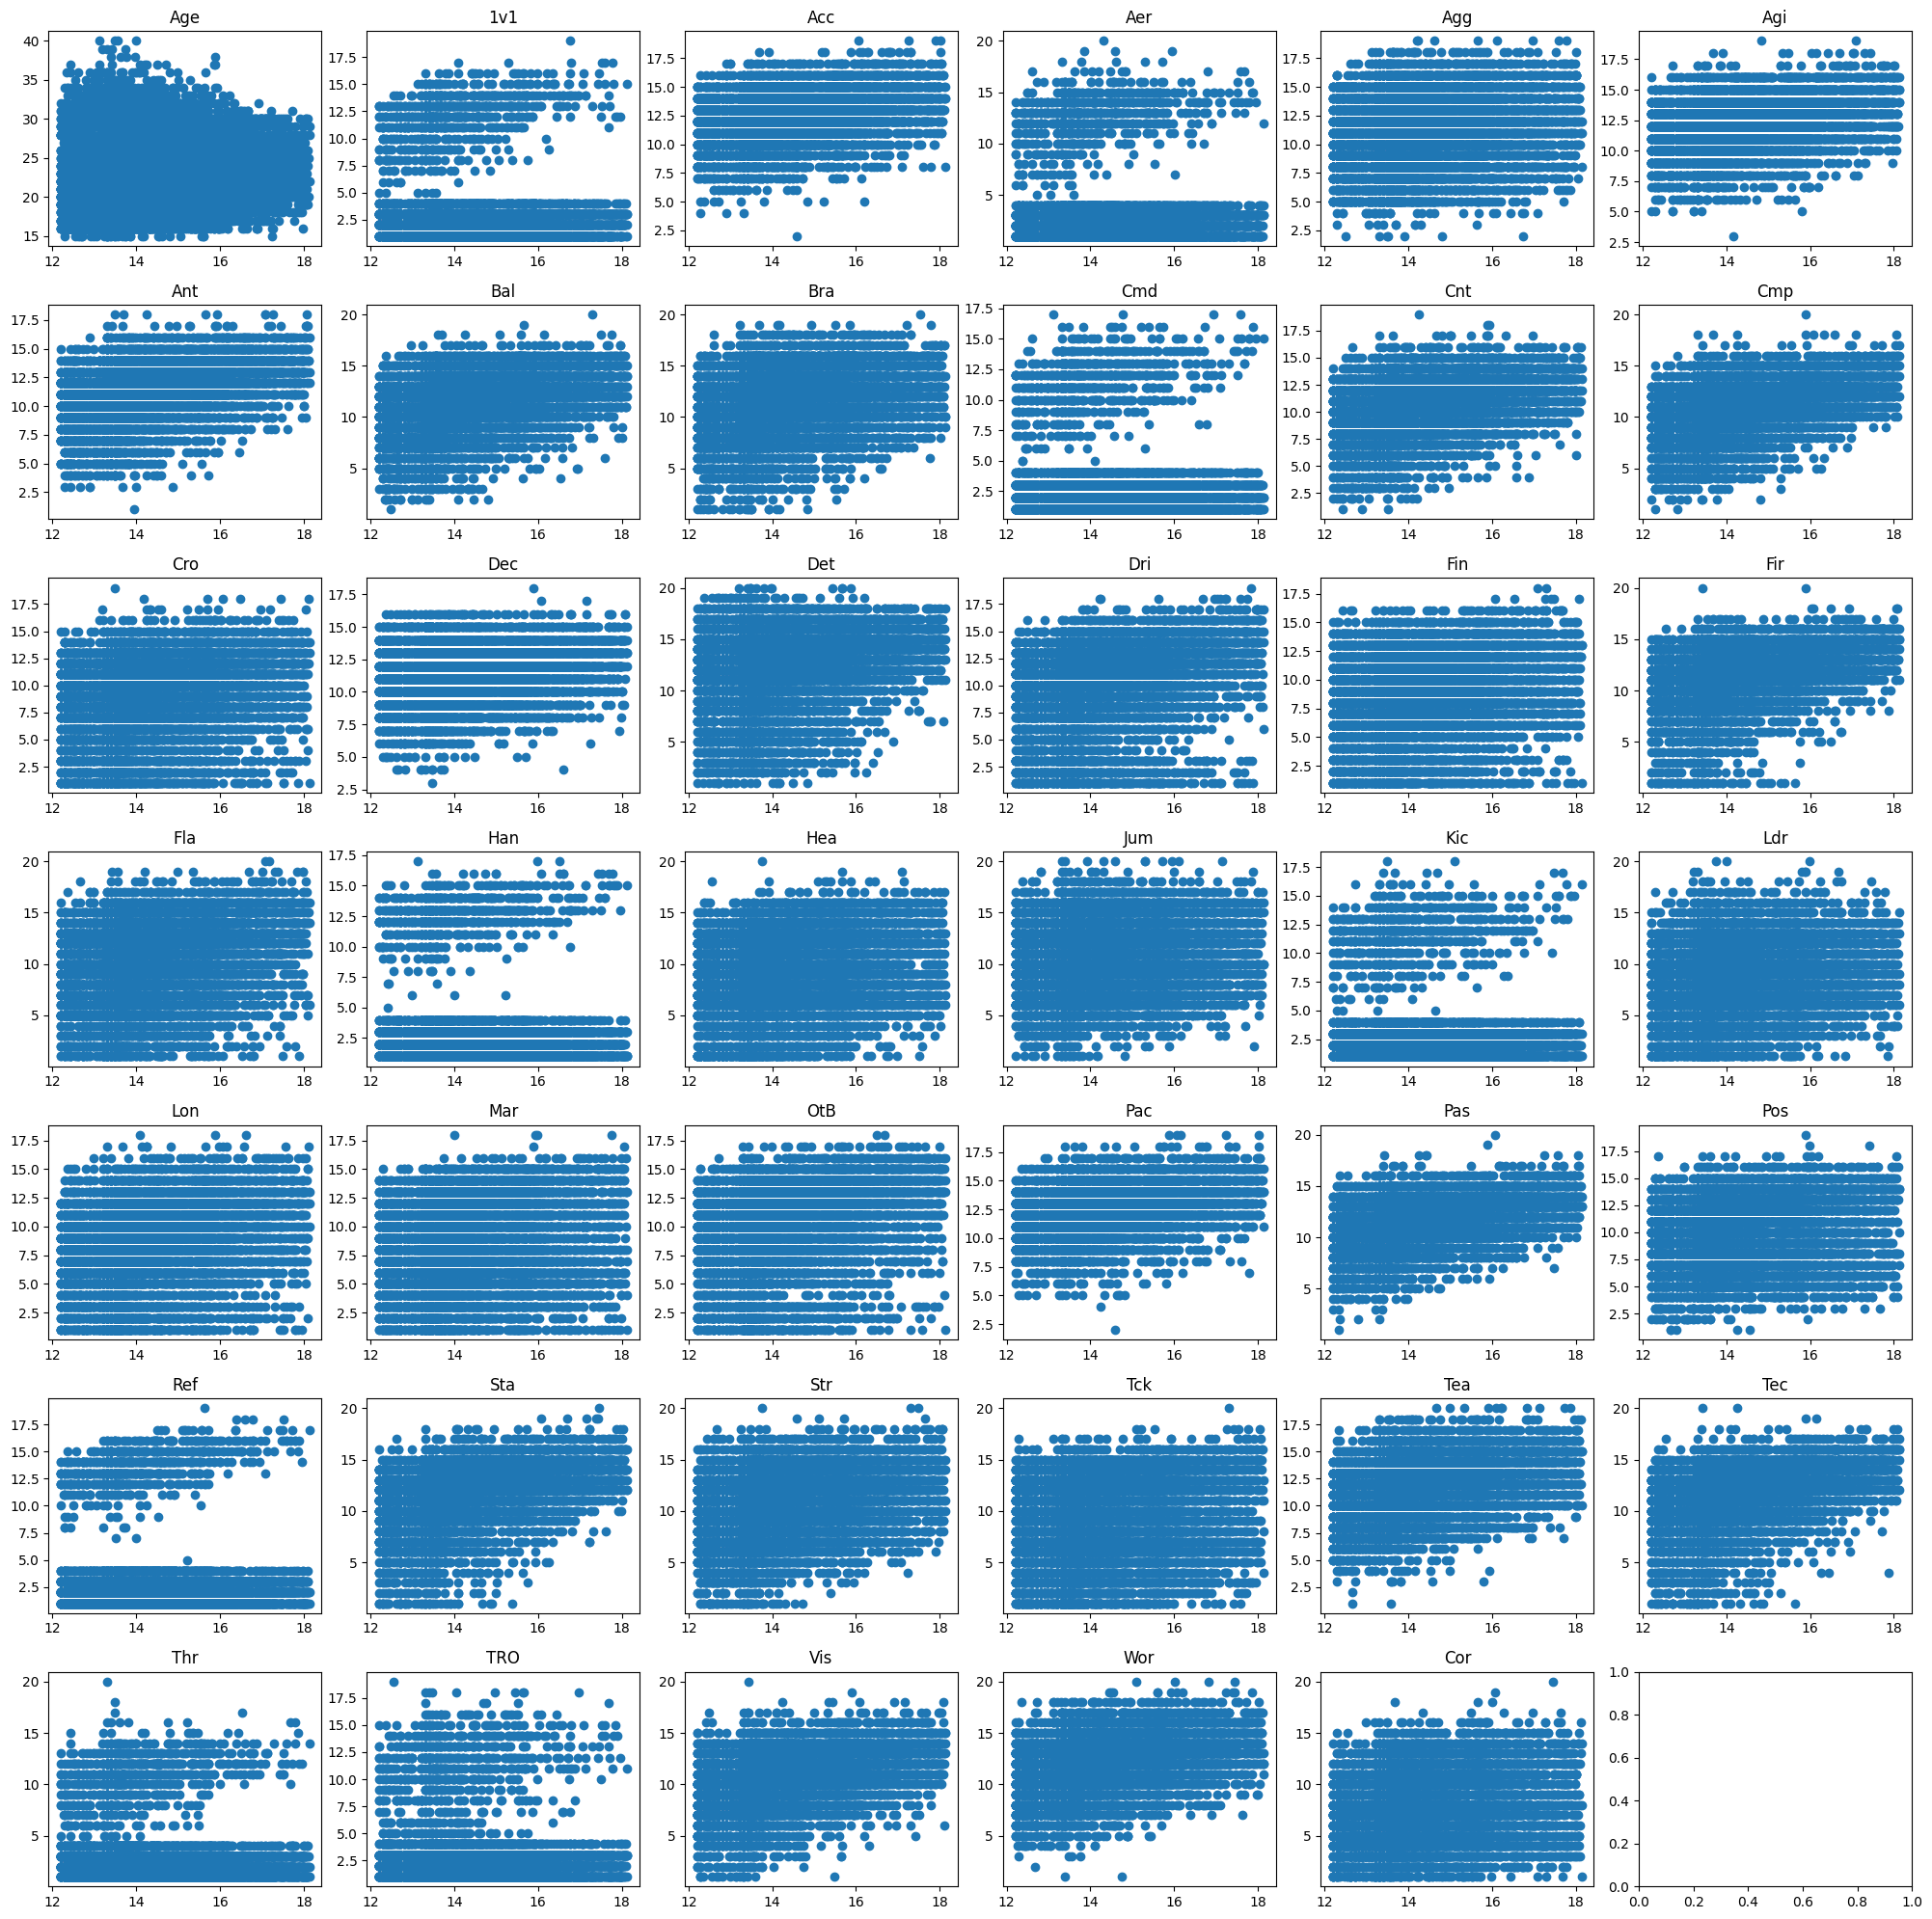

In [74]:
n_rows, n_cols = 7, 6

columns = ["Age", "1v1", "Acc", "Aer", "Agg", "Agi", "Ant", "Bal", "Bra", "Cmd", "Cnt", "Cmp", "Cro",
               "Dec", "Det", "Dri", "Fin", "Fir", "Fla", "Han", "Hea", "Jum", "Kic", "Ldr", "Lon", "Mar",
               "OtB", "Pac", "Pas", "Pos", "Ref", "Sta", "Str", "Tck", "Tea", "Tec", "Thr", "TRO", "Vis",
               "Wor", "Cor"]
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,20))
axes = axes.flatten()


#Creating a grid of scatter plots, plotting the continuous features against y
for i, col in enumerate(columns):
    axes[i].scatter(df["Log Avg Value"], df[col])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

As you can see from above, a clear insight to take from this is that the GK attributes are messing up everying else. The decision here should be to separate the model into a GK and an outfield model.

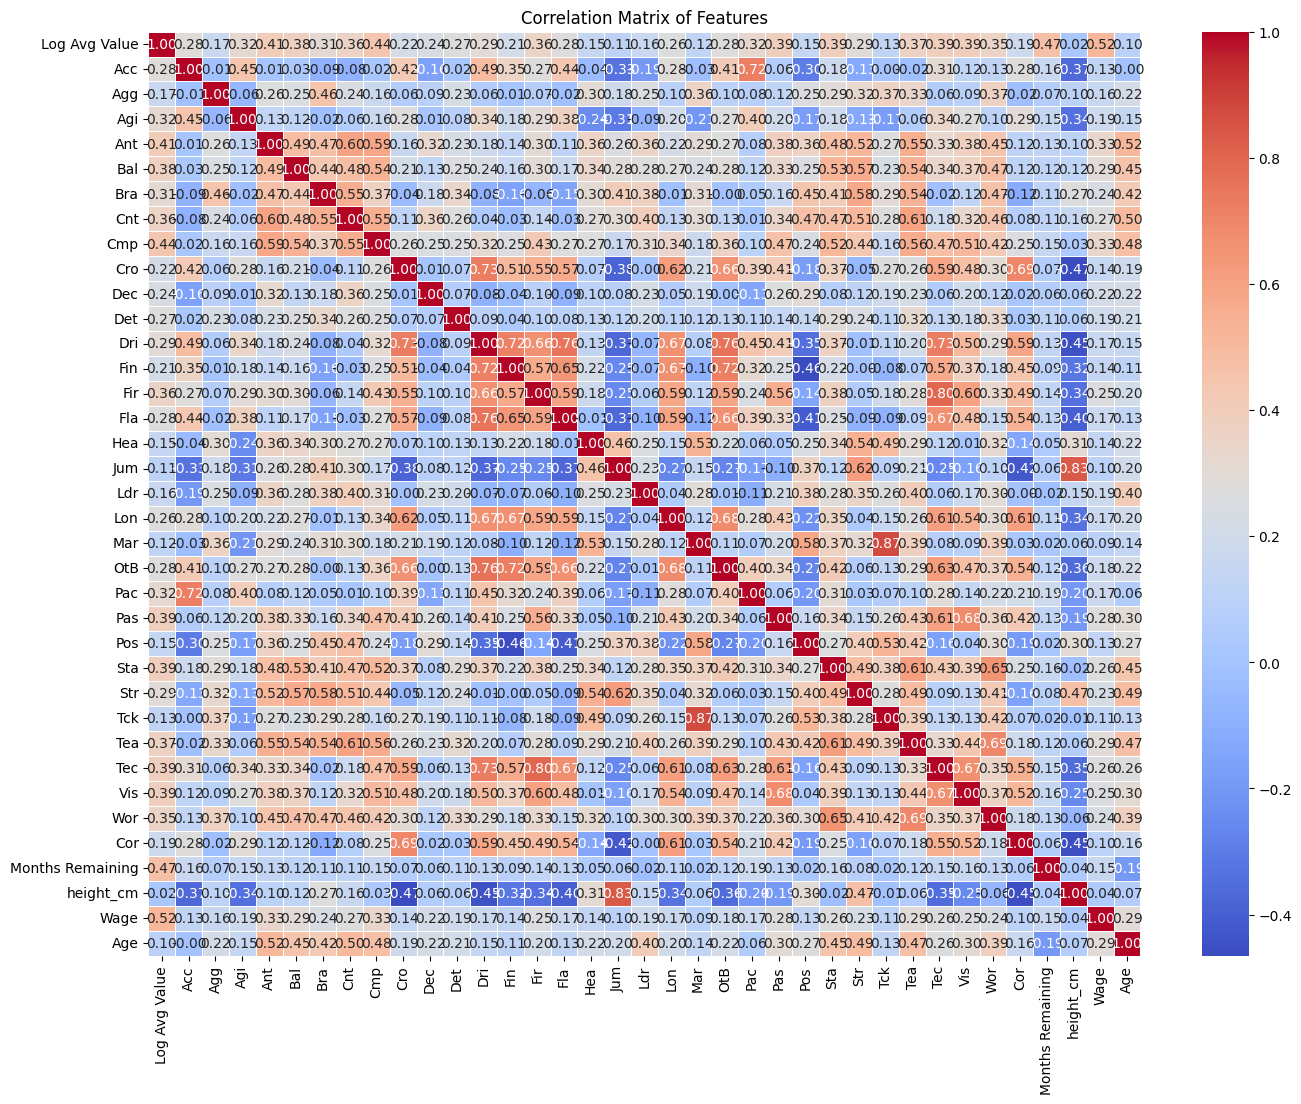

In [75]:
import seaborn as sns

corr_matrix = df[["Log Avg Value", "Acc", "Agg", "Agi", "Ant", "Bal", "Bra",  "Cnt", "Cmp", "Cro",
               "Dec", "Det", "Dri", "Fin", "Fir", "Fla",  "Hea", "Jum", "Ldr", "Lon", "Mar",
               "OtB", "Pac", "Pas", "Pos", "Sta", "Str", "Tck", "Tea", "Tec",  "Vis",
               "Wor", "Cor", "Months Remaining", "height_cm", "Wage", "Age"]].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix of Features")
plt.show()

I wouldn't say there are any bib issues with the correlation matrix, however one insight is that some features could be merged, particularly the features that have a corr score of > 0.8.

### Feature Engineering

In [76]:
# Merging attributes into features that represent training groups.

df["Aerial ability"] = (df["height_cm"] + df["Jum"]).mean()
df["Defensive Ability"] = (df["Tck"] + df["Mar"]).mean()


Next I am going to build in some categorical variables, such as league and nationality. 

As to not have lots of features produced from one-hot enconding. I am going to create a feature called "Top 5 League" and it will be a binary 1 or 0 for whether the player plays in a top 5 league.

I am also going to do something similar with player nationality. Using this study https://football-observatory.com/IMG/sites/mr/mr55/en/ to make up the top 5.

In [77]:
# Binary variable to capture top 5 league effect.
top_5_leagues = ["English Premier Division", "Ligue 1 Uber Eats", "Spanish First Division", "Bundesliga", "Italian Serie A"]
df["Division"] = df["Division"].str.strip()
df["top_5_league"] = df["Division"].isin(top_5_leagues).astype(int)



# Binary variable to capture effect from coming from top footballing nation.
nationalities = ["ENG", "BRA", "FRA", "ESP", "ARG"]
df["Nat"] = df["Nat"].str.strip()
df["top_5_nations"] = df["Nat"].isin(nationalities).astype(int)




In [78]:
from sklearn.preprocessing import StandardScaler

# Scale the continuous variables
scaler = StandardScaler()
continuous_features = ["Acc", "Agg", "Agi", "Ant", "Bal", "Bra",  "Cnt", "Cmp", "Cro",
               "Dec", "Det", "Dri", "Fin", "Fir", "Fla",  "Hea", "Jum", "Ldr", "Lon", "Mar",
               "OtB", "Pac", "Pas", "Pos", "Sta", "Str", "Tck", "Tea", "Tec",  "Vis",
               "Wor", "Cor", "Months Remaining", "height_cm", "Wage", "Age", "Aerial ability", "Defensive Ability"]
df[continuous_features] = scaler.fit_transform(df[continuous_features])


# Currently I am filtering out GK players and GK attributes from the model.
df = df[~df["Position"].str.contains("GK")]

# Creating different feature sets
X_outfield = df[["Acc", "Agg", "Agi", "Ant", "Bal", "Bra",  "Cnt", "Cmp", "Cro",
               "Dec", "Det", "Dri", "Fin", "Fir", "Fla",  "Hea", "Jum", "Ldr", "Lon", "Mar",
               "OtB", "Pac", "Pas", "Pos", "Sta", "Str", "Tck", "Tea", "Tec",  "Vis",
               "Wor", "Cor", "Months Remaining", "height_cm", "Wage", "Age", "top_5_league", "top_10_nations"]]

X_outfield_dummies = df[["Acc", "Agg", "Agi", "Ant", "Bal", "Bra",  "Cnt", "Cmp", "Cro",
               "Dec", "Det", "Dri", "Fin", "Fir", "Fla",  "Hea", "Jum", "Ldr", "Lon", "Mar",
               "OtB", "Pac", "Pas", "Pos", "Sta", "Str", "Tck", "Tea", "Tec",  "Vis",
               "Wor", "Cor", "Months Remaining", "height_cm", "Wage", "Age", "Nat", "Division"]]

X_outfield_dummies = pd.get_dummies(X_outfield_dummies, columns=["Nat", "Division"], drop_first=True)

X_outfield_merged = df[["Acc", "Agg", "Agi", "Ant", "Bal", "Bra",  "Cnt", "Cmp", "Cro",
               "Dec", "Det", "Dri", "Fin", "Fir", "Fla",  "Hea", "Ldr", "Lon",
               "OtB", "Pac", "Pas", "Pos", "Sta", "Str", "Tea", "Tec",  "Vis",
               "Wor", "Cor", "Aerial ability", "Defensive Ability",  "Months Remaining", "Wage", "Age", "top_5_league", "top_10_nations"]]

y = df["Log Avg Value"]





### Model Building

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Testing the model for all attribute features
def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)
    return model, mse, r2

default_model, r2, mse = train_model(X_outfield, y)
print(f"Default feature set: r2: {r2} | mse: {mse}")

dummies_model, r2, mse = train_model(X_outfield_dummies, y)
print(f"Dummies feature set: r2: {r2} | mse: {mse}")

merged_model, r2, mse = train_model(X_outfield_merged, y)
print(f"Merged feature set: r2: {r2} | mse: {mse}")



Default feature set: r2: 0.5790891680346687 | mse: 0.6634970527572925
Dummies feature set: r2: 0.45057593530770346 | mse: 0.7381748121757225
Merged feature set: r2: 0.5833997803585274 | mse: 0.6609921988738705


The above shows that the merged set of features make the model peform the best. I find it odd that the dummies set performs worse than the other two.

I now plan to do some cross-validation testing on each model to test for bias/variance.

In [80]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer


def cross_validation(X, y):
    # Definining the scoring function
    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

    # Definining the KFold split
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    model = LinearRegression()

    cv_scores = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)
    cv_scores = -cv_scores

    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)

    return mean_cv_score

X_outfield_mse = cross_validation(X_outfield, y)
X_outfield_dummies_mse = cross_validation(X_outfield_dummies, y)
X_outfield_merged_mse = cross_validation(X_outfield_merged, y)

print(f"Default feature set MSE: {X_outfield_mse}")
print(f"Dummies feature set MSE: {X_outfield_dummies_mse}")
print(f"Merged feature set MSE: {X_outfield_merged_mse}")

Default feature set MSE: 0.5937469219606327
Dummies feature set MSE: 8.77599590074673e+19
Merged feature set MSE: 0.5978021863293368


As you can see from above, the cross validation testing shows that the default and merged feature set perform better, the dummy feature set shows high variance, and because the bias is also worse as shown from previous set. We are going to ignore this completely.

The Merged set shows slightly higher variance but a slighly lower bias, I am going to choose this feature set.

### Model Output Analysis

In [83]:
coefficients = merged_model.coef_

coef_df = pd.DataFrame({
    "Feature": X_outfield_merged.columns,
    "Coefficient": coefficients
})

coef_df.sort_values("Coefficient", ascending=False, inplace=True)

print(coef_df)

              Feature   Coefficient
34       top_5_league  3.622940e-01
32               Wage  3.261366e-01
31   Months Remaining  2.283537e-01
0                 Acc  1.857154e-01
9                 Dec  1.450380e-01
23                Str  1.330188e-01
19                Pac  1.195487e-01
15                Hea  1.143815e-01
25                Tec  1.097472e-01
7                 Cmp  1.087659e-01
22                Sta  1.054503e-01
13                Fir  9.596118e-02
2                 Agi  8.476221e-02
20                Pas  8.152427e-02
14                Fla  8.126174e-02
3                 Ant  7.672222e-02
4                 Bal  7.512114e-02
27                Wor  7.354126e-02
21                Pos  7.296766e-02
5                 Bra  6.916525e-02
12                Fin  6.764967e-02
28                Cor  6.441299e-02
10                Det  6.391414e-02
16                Ldr  5.577379e-02
6                 Cnt  2.917414e-02
35     top_10_nations  2.770926e-02
11                Dri  2.506